# Dendritic Target Propagation in spiking neurons

In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import torch
import copy

import EIANN.EIANN as eiann
from EIANN import utils as ut
eiann.plot.update_plot_defaults()
root_dir = ut.get_project_root()

%load_ext autoreload
%autoreload 2


/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 1. Load pre-trained EIANN: 
### Dendritic Target Propagation (LDS, Top-down Weight Symmetry)

In [2]:
network_name = "20240516_EIANN_2_hidden_mnist_BP_like_config_2L_complete_optimized"
network_seed = 66049
data_seed = 257

saved_network_path = root_dir + f"/EIANN/data/mnist/{network_name}_{network_seed}_{data_seed}.pkl"
network = ut.load_network(saved_network_path)

# Load weights from a saved checkpoint halfway through training
saved_checkpoint = 100
state_dict = network.param_history[saved_checkpoint] 

# Create network object from config and load the weights
config_file_path = root_dir + f"/EIANN/network_config/mnist/{network_name}.yaml"
network = ut.build_EIANN_from_config(config_file_path, network_seed=network_seed)
network.load_state_dict(state_dict)

Loading network from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/data/mnist/20240516_EIANN_2_hidden_mnist_BP_like_config_2L_complete_optimized_66049_257.pkl'
Network successfully loaded from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/data/mnist/20240516_EIANN_2_hidden_mnist_BP_like_config_2L_complete_optimized_66049_257.pkl'


<All keys matched successfully>

### 2. Extract bottom-up and top-down inputs to a specific neuron

In [3]:
train_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders()
idx, data, target = next(iter(val_dataloader))

H2E example unit: 380


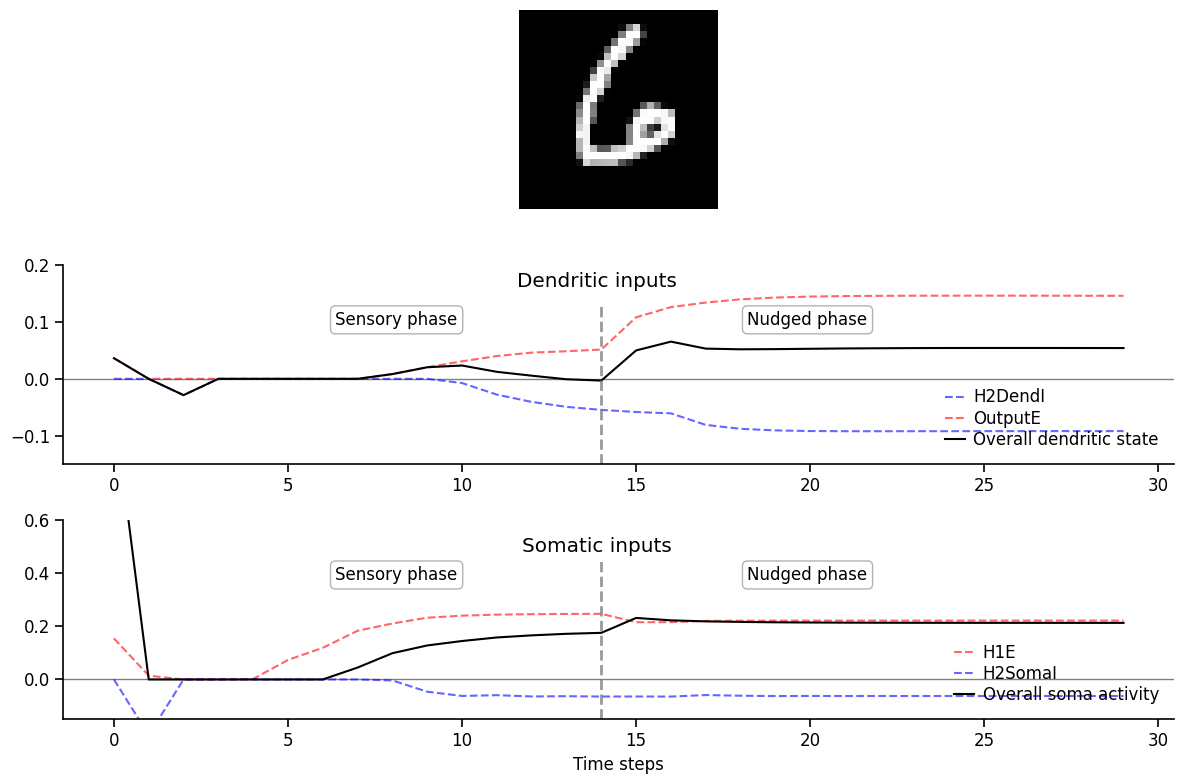

In [4]:
sample_idx = 2
data_sample = data[sample_idx]
target_sample = target[sample_idx]

output = network.forward(data_sample, store_history=True, store_dynamics=True, no_grad=False)

network.update_forward_state(store_dynamics=True, store_history=True)
for backward in network.backward_methods:
    backward(network, output, torch.squeeze(target_sample), store_history=True, store_dynamics=True)

population = network.H2.E
unit_idx = torch.argmax(population.activity_dynamics[-1])
print(f"{population.fullname} example unit: {unit_idx}")

# Create a filter mask to limit the initial activity transient
# x = np.arange(network.forward_steps)
# baseline = 0.01
# mask = baseline + (1-baseline)*(1 - np.exp(-0.5 * x))
mask = np.ones(network.forward_steps)
mask[0:3] = 0.05

fig, axes  = plt.subplots(3,1,figsize=(12,8), height_ratios=[1,1,1])
ax = axes[0]
ax.imshow(data_sample.view(28,28), cmap='Greys_r')
ax.axis('off')

ax1 = axes[1]
ax2 = axes[2]
ax1.axhline(0, color='gray', linestyle='-', linewidth=1)
ax2.axhline(0, color='gray', linestyle='-', linewidth=1)

complete_activity_dynamics = {projection.pre.fullname:[] for projection in population}
for projection in population:
    pre_pop = projection.pre
    for update_phase in ['forward', 'backward']:
        if update_phase == 'forward':
            pre_activity = pre_pop.activity_dynamics * mask.reshape(-1, 1)
        elif update_phase == 'backward':
            pre_activity = torch.stack(pre_pop.backward_steps_activity)
        complete_activity_dynamics[pre_pop.fullname].extend(pre_activity)
complete_activity_dynamics = {pop_name: torch.stack(complete_activity_dynamics[pop_name]) for pop_name in complete_activity_dynamics}

total_dend_input = []
total_soma_input = []
for projection in population:
    pre_activity = complete_activity_dynamics[projection.pre.fullname]
    synaptic_input = (projection.weight[unit_idx] * pre_activity).numpy()
    synaptic_input = synaptic_input.sum(axis=1)

    if projection.direction=='R': # Delay input by 1 timestep
        synaptic_input = np.roll(synaptic_input, 1)
        synaptic_input[0] = 0
    color = 'r' if 'E' in projection.pre.name else 'b'
    if projection.compartment == 'dend':
        ax1.plot(synaptic_input, color=color, label=projection.pre.fullname, alpha=0.6, linestyle='--')
        total_dend_input.append(synaptic_input)
    else:
        ax2.plot(synaptic_input, color=color, label=projection.pre.fullname, alpha=0.6, linestyle='--')
        total_soma_input.append(synaptic_input)

dendritic_state = np.stack(total_dend_input).sum(axis=0) # Sum total synaptic input to dend during backward phase
ax1.plot(dendritic_state, color='k', label='Overall dendritic state') 

soma_forward_activity = population.activity_dynamics[:,unit_idx]
soma_backward_activity = torch.stack(population.backward_steps_activity)[:,unit_idx]
total_soma_activity = torch.cat((soma_forward_activity, soma_backward_activity), dim=0)
ax2.plot(total_soma_activity, color='k', label='Overall soma activity')

ax1.set_ylim(-0.15, 0.2)
ax2.set_ylim(-0.15, 0.6)

ax1.axvline(14,0,0.8,color='gray',linestyle='--', linewidth=2, alpha=0.8)
ax2.axvline(14,0,0.8,color='gray',linestyle='--', linewidth=2, alpha=0.8)
ax1.legend(loc='lower right', labelspacing=0.2)
ax2.legend(loc='lower right', labelspacing=0.2)

ax1.set_title('Dendritic inputs', x=0.48, y=0.85)
ax2.set_title('Somatic inputs', x=0.48, y=0.8)
ax1.text(0.3, 0.7, 'Sensory phase', transform=ax1.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))
ax1.text(0.67, 0.7, 'Nudged phase', transform=ax1.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))
ax2.text(0.3, 0.7, 'Sensory phase', transform=ax2.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))
ax2.text(0.67, 0.7, 'Nudged phase', transform=ax2.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))

ax2.set_xlabel('Time steps')
plt.tight_layout()
plt.show()

### 3. Run spiking simulation with refractory period

In [5]:
def generate_inhomogeneous_poisson_spikes(rate, refractory_period=3):
    """
    Generate spike times from an inhomogeneous Poisson process using the thinning method.
    
    Parameters:
    -----------
    rate : numpy.ndarray
        Time series of firing rates in Hz, sampled at 1ms interval. Each element represents the instantaneous
        firing rate at that time point.
    refractory_period : float, optional
        Minimum interval between spikes in milliseconds
    
    Returns:
    --------
    list
        List of spike times in seconds
    """
    if len(rate) == 0:
        return []
    if np.any(rate < 0):
        raise ValueError("Firing rates must be non-negative")

    refractory_period_s = refractory_period / 1000.0  # Convert to seconds
    # rate = 1 / (1 / (rate+1e-10) - refractory_period_s)
    rate = rate / (1 - rate * refractory_period_s + 1e-5)    
    rate = np.clip(rate, 0, 50_000) # Avoid excessively high rates

    
    max_rate = np.max(rate) # Maximum firing rate for the homogeneous Poisson process 
    if max_rate == 0:
        return []
        
    # Generate homogeneous Poisson process at maximum rate
    total_time_s = len(rate) / 1000
    expected_events = max_rate * total_time_s

    n_events = int(np.ceil(expected_events * 2)) # Add some buffer to ensure we have enough events before thinning
    inter_spike_intervals = np.random.exponential(1.0 / max_rate, n_events) # Generate all inter-spike-intervals (drawn from exponential distribution)
    spike_times = np.cumsum(inter_spike_intervals)
    spike_times = spike_times[spike_times < total_time_s] # Reject events beyond the max simulation time
    spike_times = spike_times*1000  # Convert to milliseconds
    spike_times = list(spike_times)  # Convert to list for easier manipulation

    # Thinning: accept/reject based on instantaneous rate
    spike_times_filtered = []
    for t in spike_times:
        t_index = round(t)  # Convert from seconds to milliseconds
        if t_index == len(rate):
            continue # avoid index out of bounds

        instantaneous_rate = rate[t_index]
        accept = np.random.random() < (instantaneous_rate / max_rate)
        if len(spike_times_filtered) == 0:
            current_isi = np.inf
        else:
            current_isi = (t - spike_times_filtered[-1])

        if accept and current_isi >= refractory_period:
                spike_times_filtered.append(t)

    spike_times_filtered = np.array(spike_times_filtered).round().astype(int) # Round to nearest ms
    return spike_times_filtered

# rate = np.linspace(300)  # Example rate in Hz
# rate = np.arange(500)  # Example rate in Hz
# rate = 300 * np.ones(1000)  # Example rate in Hz
# spike_times = generate_inhomogeneous_poisson_spikes(rate, refractory_period=2)

# plt.eventplot(spike_times, linelengths=0.5, linewidths=1)
# len(spike_times)  # Number of spikes generated


In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"{population.fullname} example unit: {unit_idx}")

# Simulation parameters
time_coefficient = 20  # ms per time step
refractory_period = 1.  # ms

time_steps = network.forward_steps * time_coefficient * 2
print(f"Simulation length: {time_steps} ms")

##################################################
# Convert RNN activations to Poisson rates (in Hz)
##################################################
weight_scale = 2.5
pre_spike_times = {}
pre_spikes = {}
soma_currents = {}
dend_currents = {}
eligibility_traces = {}

poisson_rates = {}
max_rate = 300.0  # Hz, scale factor for maximum firing rate
for projection in population:
    # Expand activity dynamics to match simulation time resolution, convert units to firing rates
    activity_dynamics_expanded = torch.tensor(scipy.ndimage.zoom(complete_activity_dynamics[projection.pre.fullname], (time_coefficient , 1), order=1))
    poisson_rates[projection.pre.fullname] = torch.clip(max_rate * activity_dynamics_expanded, 0, 1000/(refractory_period)) # Clip max rate to based on refractory period
    if projection.direction == 'R':
        poisson_rates[projection.pre.fullname] = torch.roll(poisson_rates[projection.pre.fullname], 1*time_coefficient, dims=0)
        poisson_rates[projection.pre.fullname][0:time_coefficient] *= 0

    # Generate Poisson spikes for presynaptic neurons
    num_neurons = poisson_rates[projection.pre.fullname].shape[1]
    pre_spike_times[projection.pre.fullname] = []
    pre_spikes[projection.pre.fullname] = np.zeros((time_steps, num_neurons))
    for neuron_idx in range(num_neurons):
        unit_rate = poisson_rates[projection.pre.fullname][:, neuron_idx].numpy()
        unit_spike_times = generate_inhomogeneous_poisson_spikes(unit_rate, refractory_period)
        pre_spike_times[projection.pre.fullname].append(unit_spike_times)
        if len(unit_spike_times) > 0:
            unit_spikes = scipy.signal.unit_impulse(time_steps, idx=unit_spike_times)
            pre_spikes[projection.pre.fullname][:, neuron_idx] = unit_spikes

    # Compute input currents from presynaptic spikes
    synaptic_weights = projection.weight[unit_idx] * weight_scale
    input_current = synaptic_weights * pre_spikes[projection.pre.fullname]
    if projection.compartment == 'dend':
        dend_currents[projection.pre.fullname] = input_current
    else:
        soma_currents[projection.pre.fullname] = input_current


#########################
# Main simulation loop
#########################
# Neuron parameters
tau_neuron = network.tau * time_coefficient
tau_dend = 2 * time_coefficient
tau_ET = 2 * time_coefficient
print(f"Membrane time constant: {tau_neuron} ms")
print(f"Dendritic time constant: {tau_dend} ms")
print(f"Eligibility trace time constant: {tau_ET} ms")

# Initialize variables
v_membrane = 0
v_dend = 0
dend_IS = 0
ET_values = {pre_pop: np.zeros(spikes.shape[1]) for pre_pop,spikes in pre_spikes.items()}                  

soma_voltage_trace = [ ]
dend_voltage_trace = []
total_soma_current_trace = []
total_dend_current_trace = []
dend_IS_trace = []
eligibility_traces = {pre_pop: [] for pre_pop in pre_spikes}

for t in range(time_steps):
    total_dend_current = 0
    for pre_pop in dend_currents:
        input_currents = dend_currents[pre_pop][t].numpy()
        total_dend_current += input_currents.sum().item()
        delta_ET = -ET_values[pre_pop] + pre_spikes[pre_pop][t]*weight_scale
        ET_values[pre_pop] += delta_ET/tau_ET
        eligibility_traces[pre_pop].append(ET_values[pre_pop].copy())

    total_soma_current = 0
    for pre_pop in soma_currents:
        input_currents = soma_currents[pre_pop][t].numpy()
        total_soma_current += input_currents.sum().item()
        delta_ET = -ET_values[pre_pop]  + pre_spikes[pre_pop][t]*weight_scale
        ET_values[pre_pop] += delta_ET/tau_ET
        eligibility_traces[pre_pop].append(ET_values[pre_pop].copy())
        
    dvdt_dend = -v_dend + total_dend_current
    v_dend += dvdt_dend / tau_dend
        
    # total_soma_current += v_dend*10
    dvdt_soma = -v_membrane + total_soma_current
    v_membrane += dvdt_soma / tau_neuron
    
    soma_voltage_trace.append(v_membrane)
    dend_voltage_trace.append(v_dend)
    total_soma_current_trace.append(total_soma_current)
    total_dend_current_trace.append(total_dend_current)
    
eligibility_traces = {pre_pop: np.array(eligibility_traces[pre_pop]) for pre_pop in eligibility_traces}

H2E example unit: 380
Simulation length: 600 ms
Membrane time constant: 60 ms
Dendritic time constant: 40 ms
Eligibility trace time constant: 40 ms


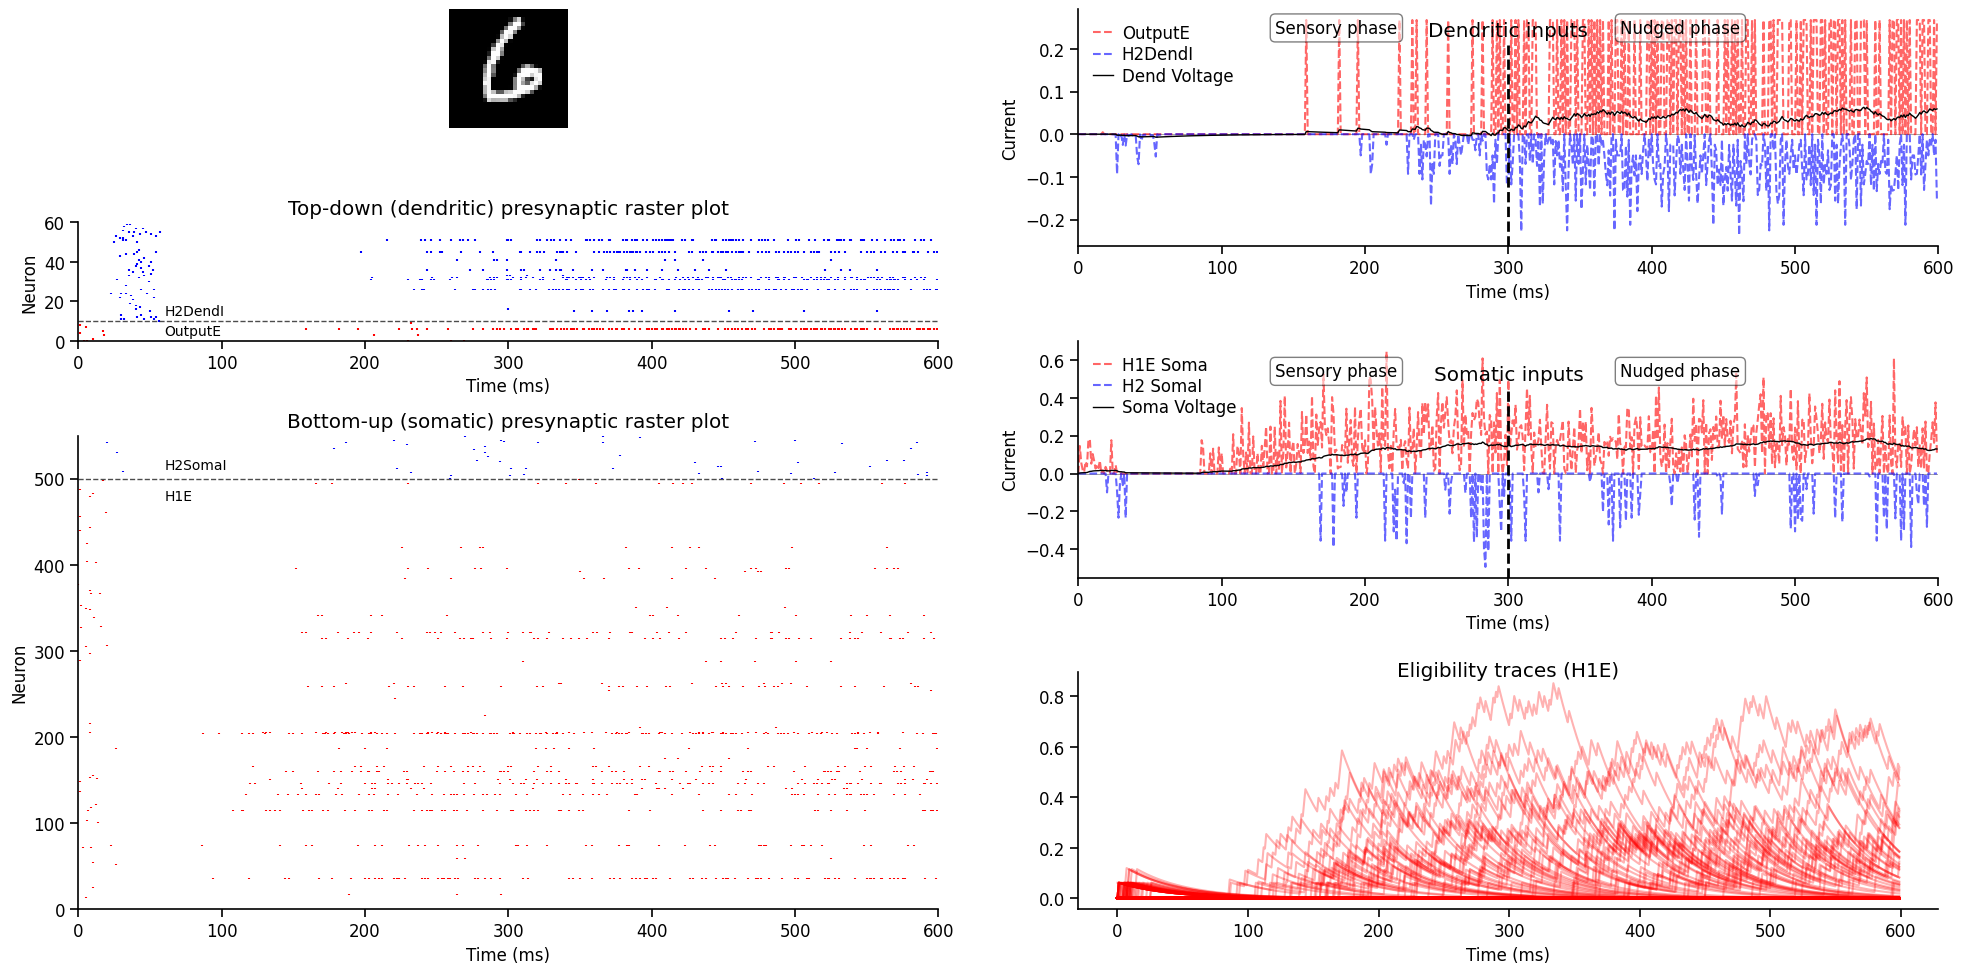

In [14]:
# Plotting
import matplotlib.gridspec as gs

# fig, axes = plt.subplots(3, 2, figsize=(20, 10), gridspec_kw={'height_ratios': [1,1,1], 'hspace': 0.6, 'wspace': 0.2})
fig = plt.figure(figsize=(20, 10))
axes_left = gs.GridSpec(3, 1, figure=fig, left=0.05, right=0.48, top=0.95, bottom=0.05, hspace=0.4, height_ratios=[1,1,4])
axes_right = gs.GridSpec(3, 1, figure=fig, left=0.55, right=0.98, top=0.95, bottom=0.05, hspace=0.4, height_ratios=[1,1,1])

time_axis = np.arange(time_steps)

# Plot input image
ax = fig.add_subplot(axes_left[0])
ax.imshow(data_sample.view(28,28), cmap='Greys_r')
ax.axis('off')

# Dendritic input raster plot
ax = fig.add_subplot(axes_left[1])
num_neurons_E = len(pre_spike_times['OutputE'])
num_neurons_I = len(pre_spike_times['H2DendI'])
ax.eventplot(pre_spike_times['OutputE'], colors='r', linelengths=0.8)
ax.eventplot(pre_spike_times['H2DendI'], colors='b', linelengths=0.8, lineoffsets=np.arange(num_neurons_E, num_neurons_E + num_neurons_I))
ax.axhline(y=num_neurons_E, color='k', linestyle='--', alpha=0.7, linewidth=1)
ax.text(len(time_axis)*0.1, num_neurons_E-5, 'OutputE', fontsize=10, verticalalignment='center')
ax.text(len(time_axis)*0.1, num_neurons_E+5, 'H2DendI', fontsize=10, verticalalignment='center')
ax.set_title('Top-down (dendritic) presynaptic raster plot')
ax.set_ylabel('Neuron')
ax.set_xlabel("Time (ms)")
ax.set_xlim(0, len(time_axis))
ax.set_ylim(0, num_neurons_E + num_neurons_I)

# Somatic input raster plot
ax = fig.add_subplot(axes_left[2])
num_neurons_H1E = len(pre_spike_times['H1E'])
num_neurons_H2SomaI = len(pre_spike_times['H2SomaI'])
ax.eventplot(pre_spike_times['H1E'], colors='r', linelengths=0.8)
ax.eventplot(pre_spike_times['H2SomaI'], colors='b', linelengths=0.8, lineoffsets=np.arange(num_neurons_H1E, num_neurons_H1E + num_neurons_H2SomaI))
ax.axhline(y=num_neurons_H1E, color='k', linestyle='--', alpha=0.7, linewidth=1)
ax.text(len(time_axis)*0.1, num_neurons_H1E-20, 'H1E', fontsize=10, verticalalignment='center')
ax.text(len(time_axis)*0.1, num_neurons_H1E+15, 'H2SomaI', fontsize=10, verticalalignment='center')
ax.set_title('Bottom-up (somatic) presynaptic raster plot')
ax.set_ylabel('Neuron')
ax.set_xlabel("Time (ms)")
ax.set_xlim(0, len(time_axis))
ax.set_ylim(0, num_neurons_H1E + num_neurons_H2SomaI)

# Plot dendritic input currents
ax = fig.add_subplot(axes_right[0])
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax.plot(dend_currents['OutputE'].sum(dim=1), label='OutputE', color='r', alpha=0.6, linestyle='--')
ax.plot(dend_currents['H2DendI'].sum(dim=1), label='H2DendI', color='b', alpha=0.6, linestyle='--')
ax.plot(dend_voltage_trace, 'k-', linewidth=1, label='Dend Voltage')
ax.set_ylabel('Current')
ax.set_xlabel("Time (ms)")
ax.set_xlim(0, len(time_axis))
# ax.set_ylim(-10, 10)
ax.axvline(time_steps/2,0,0.85,color='k',linestyle='--', linewidth=2, alpha=1)
ax.legend(loc='upper left', labelspacing=0.2)
# ax.set_title('Dendritic inputs', x=0.42, y=0.8)
ax.set_title('Dendritic inputs', x=0.5, y=0.85)
ax.text(0.3, 0.9, 'Sensory phase', transform=ax.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))
ax.text(0.7, 0.9, 'Nudged phase', transform=ax.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))


# Plot somatic input currents
ax = fig.add_subplot(axes_right[1])
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
ax.plot(soma_currents['H1E'].sum(dim=1), label='H1E Soma', color='r', alpha=0.6, linestyle='--')
ax.plot(soma_currents['H2SomaI'].sum(dim=1), label='H2 SomaI', color='b', alpha=0.6, linestyle='--')
ax.plot(soma_voltage_trace, 'k-', linewidth=1, label='Soma Voltage')
ax.set_ylabel('Current')
ax.set_xlabel("Time (ms)")
ax.set_xlim(0, len(time_axis))
# ax.set_ylim(-20, 30)
ax.axvline(time_steps/2,0,0.8,color='k',linestyle='--', linewidth=2, alpha=1)
ax.legend(loc='upper left', labelspacing=0.2)
ax.set_title('Somatic inputs', x=0.5, y=0.8)
ax.text(0.3, 0.85, 'Sensory phase', transform=ax.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))
ax.text(0.7, 0.85, 'Nudged phase', transform=ax.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))

# Plot eligibility traces
ax = fig.add_subplot(axes_right[2])
ax.plot(eligibility_traces['H1E'], label='H1E', color='r', alpha=0.3, linestyle='-')
ax.set_title('Eligibility traces (H1E)', x=0.5, y=0.95)

ax.set_xlabel("Time (ms)")
plt.show()

#### Compare dW for rate vs spiking models

In [15]:
initial_params = copy.deepcopy(network.state_dict()) # Store parameters for dW comparison
for layer in network:
    for pop in layer:
        for projection in pop:
            projection.learning_rule.step()
updated_params = copy.deepcopy(network.state_dict()) # Store parameters for dW comparison

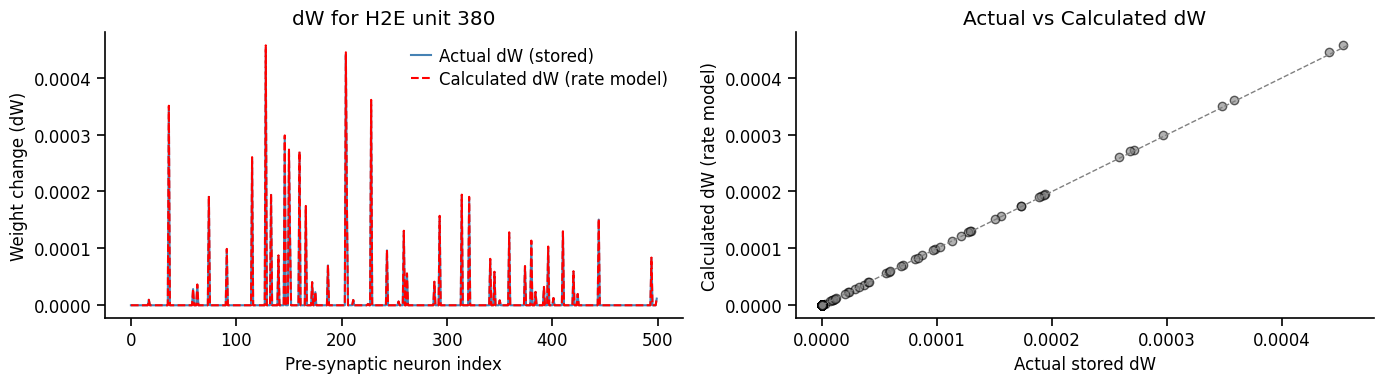

In [16]:
proj_name = 'H2E_H1E'

dW_H1E = updated_params[f'module_dict.{proj_name}.weight'] - initial_params[f'module_dict.{proj_name}.weight']
learning_rate = network.projections[proj_name].learning_rule.learning_rate
final_activity = complete_activity_dynamics['H1E'][-1]
final_dend_state = dendritic_state[-1]
rate_dW = final_activity * final_dend_state * learning_rate

fig, ax = plt.subplots(1,2,figsize=(14, 4))
ax[0].plot(dW_H1E[unit_idx], color='steelblue', label='Actual dW (stored)')
ax[0].plot(rate_dW, color='r', label='Calculated dW (rate model)', linestyle='--')
ax[0].set_title(f'dW for {population.fullname} unit {unit_idx}')
ax[0].set_xlabel('Pre-synaptic neuron index')
ax[0].set_ylabel('Weight change (dW)')
ax[0].legend()

# Right: scatter plot of actual vs calculated dW
ax[1].scatter(dW_H1E[unit_idx], rate_dW, color='k', alpha=0.6, facecolor='gray', edgecolor='k')
ax[1].set_xlabel('Actual stored dW')
ax[1].set_ylabel('Calculated dW (rate model)')
max_val = max(torch.max(dW_H1E[unit_idx]), torch.max(rate_dW))
min_val = min(torch.min(dW_H1E[unit_idx]), torch.min(rate_dW))
ax[1].plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)
ax[1].set_title('Actual vs Calculated dW')
plt.tight_layout()
plt.show()

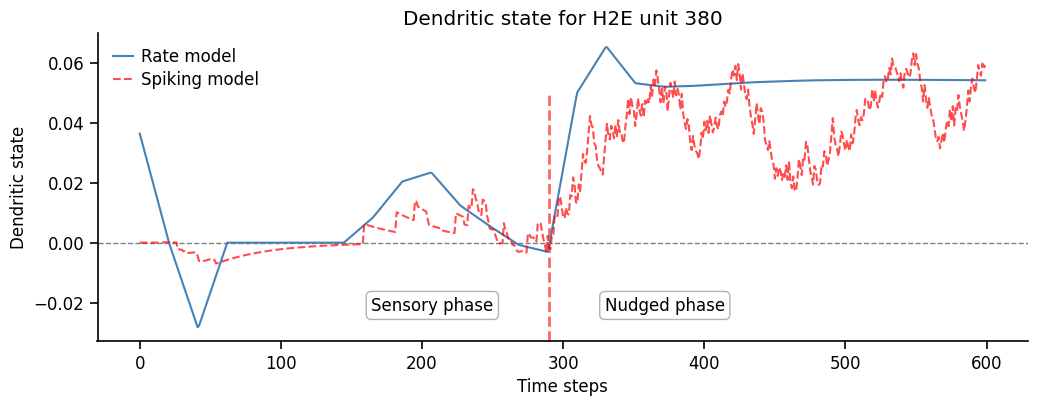

In [17]:
dendritic_state_expanded = torch.tensor(scipy.ndimage.zoom(dendritic_state, time_coefficient, order=1))

fig, ax = plt.subplots(1,1,figsize=(12, 4))
ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline((time_steps-time_coefficient)/2, 0,0.8,color='r',linestyle='--', linewidth=2, alpha=0.6)
ax.plot(dendritic_state_expanded, color='steelblue', label='Rate model')
ax.plot(dend_voltage_trace, color='r', label='Spiking model', linestyle='--', alpha=0.7)
ax.set_title(f"Dendritic state for {population.fullname} unit {unit_idx}")
ax.text(0.36, 0.1, 'Sensory phase', transform=ax.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))
ax.text(0.61, 0.1, 'Nudged phase', transform=ax.transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.3, boxstyle='round,pad=0.3'))
ax.set_xlabel('Time steps')
ax.set_ylabel('Dendritic state')
ax.legend()
plt.show()

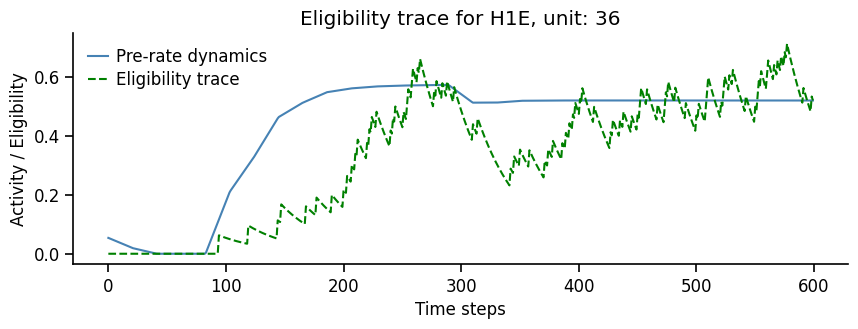

In [18]:
pre_unit_idx = 36
rate_dynamics = torch.tensor(scipy.ndimage.zoom(complete_activity_dynamics['H1E'][:, pre_unit_idx], time_coefficient, order=1))
plt.plot(rate_dynamics, label='Pre-rate dynamics', color='steelblue')
plt.plot(eligibility_traces['H1E'][:, pre_unit_idx], label='Eligibility trace', color='green', linestyle='--')
plt.title(f"Eligibility trace for H1E, unit: {pre_unit_idx}")
plt.xlabel('Time steps')
plt.ylabel('Activity / Eligibility')
plt.legend()
plt.show()

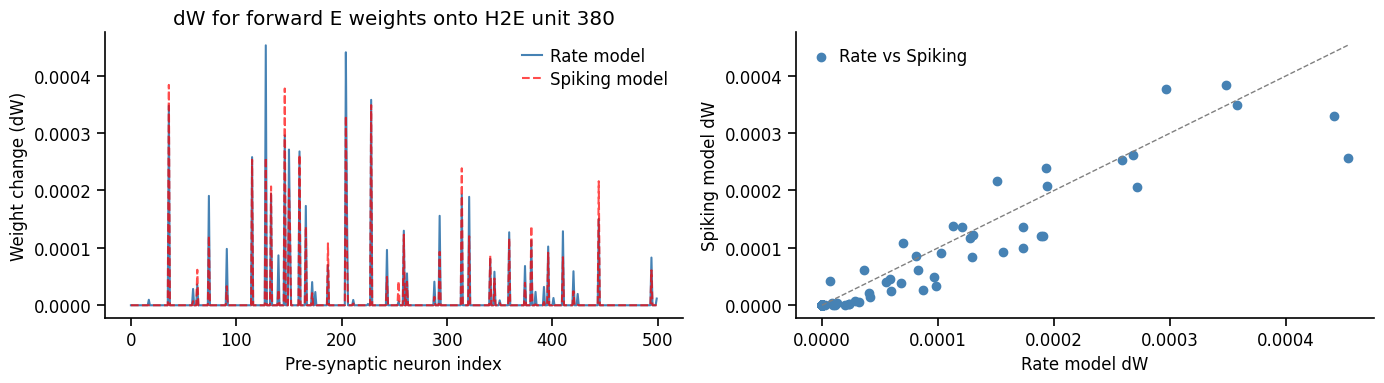

In [19]:
learning_rate = network.projections['H2E_H1E'].learning_rule.learning_rate
final_el_traces = eligibility_traces['H1E'][-1]
final_dend_state = dend_voltage_trace[-1]
spiking_dW = final_el_traces * final_dend_state * learning_rate

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(dW_H1E[unit_idx], color='steelblue', label='Rate model')
axes[0].plot(spiking_dW, color='r', label='Spiking model', linestyle='--', alpha=0.7)
axes[0].set_title(f'dW for forward E weights onto {population.fullname} unit {unit_idx}')
axes[0].set_xlabel('Pre-synaptic neuron index')
axes[0].set_ylabel('Weight change (dW)')
axes[0].legend()

axes[1].scatter(dW_H1E[unit_idx], spiking_dW, color='steelblue', label='Rate vs Spiking')
axes[1].set_xlabel('Rate model dW')
axes[1].set_ylabel('Spiking model dW')
max_val = max(torch.max(dW_H1E[unit_idx]), np.max(spiking_dW))
min_val = min(torch.min(dW_H1E[unit_idx]), np.min(spiking_dW))
axes[1].plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=1)


axes[1].legend()

plt.tight_layout()
plt.show()